#hybrid_models

In [1]:
#!git clone https://github.com/leonardoLavagna/qaoa

In [2]:
import os
os.chdir("qaoa")

In [3]:
#!pip install -r requirements.txt
#!pip install torch_geometric
#!pip install pennylane
#!pip install torch
#!pip install scikit-learn

In [4]:
import sys
import torch
import random
import pickle
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml
import networkx as nx
from sklearn.model_selection import train_test_split
from torch_geometric.nn import global_mean_pool
from torch_geometric.data import Data, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [5]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

def exact_maxcut(q_s):
    n = q_s.shape[0]
    max_cut = 0
    for partition in range(1, 1 << (n - 1)):
        A = [i for i in range(n) if partition & (1 << i)]
        B = [i for i in range(n) if not (partition & (1 << i))]
        cut_value = sum(abs(q_s[i, j]) for i in A for j in B)
        max_cut = max(max_cut, cut_value)
    return max_cut

def graph_to_vector(adj, cut):
    edge_weights = adj[np.triu_indices(adj.shape[0], k=1)]
    return torch.tensor(edge_weights, dtype=torch.float32), torch.tensor([cut], dtype=torch.float32)

def graph_to_pyg(adj, cut, max_nodes=6):
    n = adj.shape[0]
    edge_index = torch.combinations(torch.arange(n), r=2).t()
    edge_weights = adj[np.triu_indices(n, k=1)]
    x = F.pad(torch.eye(n), (0, max_nodes - n), value=0)
    return Data(
        x=x,
        edge_index=edge_index,
        edge_attr=torch.tensor(edge_weights, dtype=torch.float32).unsqueeze(1),
        y=torch.tensor([cut], dtype=torch.float32)
    )

def load_graphs_from_nx(data_dir="data/", max_nodes=100):
    data_pyg, data_vec = [], []
    for fname in os.listdir(data_dir):
        if not fname.endswith(".nx"):
            continue
        with open(os.path.join(data_dir, fname), "rb") as f:
            graph_wrapper = pickle.load(f)
            G = graph_wrapper.get_graph()
        A = nx.to_numpy_array(G)
        cut = exact_maxcut(A)
        data_vec.append(graph_to_vector(A, cut))
        data_pyg.append(graph_to_pyg(A, cut, max_nodes=max_nodes))
    return train_test_split(data_pyg, test_size=0.2), train_test_split(data_vec, test_size=0.2)

def pad_vectors(data_vec, max_len=None):
    if max_len is None:
        max_len = max(x.shape[0] for x, _ in data_vec)
    padded_x, y_values = [], []
    for x, y in data_vec:
        x_padded = F.pad(x, (0, max_len - x.shape[0]), value=0)
        padded_x.append(x_padded)
        y_values.append(y)
    return torch.stack(padded_x), torch.stack(y_values), max_len

In [6]:
class QuantumLayer(nn.Module):
    def __init__(self, n_qubits, n_layers):
        super().__init__()
        self.dev = qml.device("default.qubit", wires=n_qubits)

        @qml.qnode(self.dev, interface="torch")
        def circuit(inputs, weights):
            for i in range(n_qubits):
                qml.RY(inputs[i], wires=i)
            for l in range(n_layers):
                for i in range(n_qubits):
                    qml.RZ(weights[l, i, 0], wires=i)
                    qml.RY(weights[l, i, 1], wires=i)
                for i in range(n_qubits - 1):
                    qml.CNOT(wires=[i, i + 1])
                qml.CNOT(wires=[n_qubits - 1, 0])
            return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

        weight_shapes = {"weights": (n_layers, n_qubits, 2)}
        self.qnn = qml.qnn.TorchLayer(circuit, weight_shapes)

    def forward(self, x):
        return torch.stack([self.qnn(v) for v in x])

class QuantumMLP(nn.Module):
    def __init__(self, input_dim=15, n_qubits=6, n_layers=2):
        super().__init__()
        self.fc = nn.Linear(input_dim, n_qubits)
        self.qnn = QuantumLayer(n_qubits, n_layers)
        self.out = nn.Linear(n_qubits, 1)

    def forward(self, x):
        x = torch.tanh(self.fc(x)) * torch.pi
        x = self.qnn(x)
        return self.out(x)

class HybridLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=16, n_qubits=6, n_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, n_qubits)
        self.qnn = QuantumLayer(n_qubits, n_layers)
        self.out = nn.Linear(n_qubits, 1)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        x = torch.tanh(self.fc(hn[-1])) * torch.pi
        x = self.qnn(x)
        return self.out(x)

class QNodeEmbedding(nn.Module):
    def __init__(self, n_qubits=4, n_layers=2):
        super().__init__()
        self.dev = qml.device("default.qubit", wires=n_qubits)

        @qml.qnode(self.dev, interface="torch")
        def circuit(inputs, weights):
            for i in range(n_qubits):
                qml.RY(inputs[i], wires=i)
            for l in range(n_layers):
                for i in range(n_qubits):
                    qml.RZ(weights[l, i, 0], wires=i)
                    qml.RY(weights[l, i, 1], wires=i)
                for i in range(n_qubits - 1):
                    qml.CNOT(wires=[i, i + 1])
                qml.CNOT(wires=[n_qubits - 1, 0])
            return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

        weight_shapes = {"weights": (n_layers, n_qubits, 2)}
        self.qnn = qml.qnn.TorchLayer(circuit, weight_shapes)

    def forward(self, x):
        return torch.stack([self.qnn(v) for v in x])

class QuantumGNN(nn.Module):
    def __init__(self, input_dim, quantum_dim=4, qlayers=2):
        super().__init__()
        self.encoder = nn.Linear(input_dim, quantum_dim)
        self.quantum = QNodeEmbedding(n_qubits=quantum_dim, n_layers=qlayers)
        self.out = nn.Linear(quantum_dim, 1)

    def forward(self, data):
        x = torch.tanh(self.encoder(data.x)) * torch.pi
        x = self.quantum(x)
        x = global_mean_pool(x, data.batch)
        return self.out(x)

In [7]:
def train(model, X_train, y_train, X_test, y_test, name="Model", epochs=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.MSELoss()
    losses = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(X_train).squeeze()
        loss = loss_fn(out, y_train.squeeze())
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        print(f"[{name}] Epoch {epoch+1}: Loss = {loss.item():.4f}")
    model.eval()
    with torch.no_grad():
        preds = model(X_test).squeeze()
    return preds.tolist(), y_test.squeeze().tolist(), losses


def train_gnn(model, train_data, test_data, name="QGNN", epochs=100):
    loader = DataLoader(train_data, batch_size=16, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.MSELoss()
    losses = []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch in loader:
            optimizer.zero_grad()
            out = model(batch).squeeze()
            loss = loss_fn(out, batch.y.squeeze())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        losses.append(epoch_loss / len(loader))
        print(f"[{name}] Epoch {epoch+1}: Loss = {losses[-1]:.4f}")
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for g in test_data:
            pred = model(g).item()
            preds.append(pred)
            targets.append(g.y.item())
    return preds, targets, losses

In [8]:
runs = 10
model_names = ["QuantumMLP", "HybridLSTM", "QuantumGNN"]

all_losses = {name: [] for name in model_names}
all_preds = {name: [] for name in model_names}
all_trues = []

for run in range(runs):
    print(f"\n=== Seeded Run {run+1} ===")
    set_seed(run)
    (pyg_train, pyg_test), (vec_train, vec_test) = load_graphs_from_nx(data_dir="data/")
    X_train, y_train, max_len = pad_vectors(vec_train)
    X_test, y_test, _ = pad_vectors(vec_test, max_len=max_len)
    qmlp = QuantumMLP(input_dim=X_train.shape[1])
    preds, true, losses = train(qmlp, X_train, y_train, X_test, y_test, name="QuantumMLP")
    all_losses["QuantumMLP"].append(losses)
    all_preds["QuantumMLP"].append(preds)
    if run == 0:
        all_trues = true
    qlstm = HybridLSTM(input_dim=X_train.shape[1])
    X_train_seq = X_train.unsqueeze(1)
    X_test_seq = X_test.unsqueeze(1)
    preds, _, losses = train(qlstm, X_train_seq, y_train, X_test_seq, y_test, name="HybridLSTM")
    all_losses["HybridLSTM"].append(losses)
    all_preds["HybridLSTM"].append(preds)
    qgnn = QuantumGNN(input_dim=pyg_train[0].x.shape[1])
    preds, _, losses = train_gnn(qgnn, pyg_train, pyg_test, name="QuantumGNN")
    all_losses["QuantumGNN"].append(losses)
    all_preds["QuantumGNN"].append(preds)


=== Seeded Run 1 ===
[QuantumMLP] Epoch 1: Loss = 122.9124
[QuantumMLP] Epoch 2: Loss = 122.5133
[QuantumMLP] Epoch 3: Loss = 122.3097
[QuantumMLP] Epoch 4: Loss = 121.9697
[QuantumMLP] Epoch 5: Loss = 121.5359
[QuantumMLP] Epoch 6: Loss = 120.9965
[QuantumMLP] Epoch 7: Loss = 120.4694
[QuantumMLP] Epoch 8: Loss = 120.2983
[QuantumMLP] Epoch 9: Loss = 119.9123
[QuantumMLP] Epoch 10: Loss = 119.3518
[QuantumMLP] Epoch 11: Loss = 118.9459
[QuantumMLP] Epoch 12: Loss = 118.5989
[QuantumMLP] Epoch 13: Loss = 118.1020
[QuantumMLP] Epoch 14: Loss = 117.6259
[QuantumMLP] Epoch 15: Loss = 117.3074
[QuantumMLP] Epoch 16: Loss = 116.8727
[QuantumMLP] Epoch 17: Loss = 116.3455
[QuantumMLP] Epoch 18: Loss = 115.9167
[QuantumMLP] Epoch 19: Loss = 115.4296
[QuantumMLP] Epoch 20: Loss = 114.8190
[QuantumMLP] Epoch 21: Loss = 114.3444
[QuantumMLP] Epoch 22: Loss = 113.7851
[QuantumMLP] Epoch 23: Loss = 113.1602
[QuantumMLP] Epoch 24: Loss = 112.5941
[QuantumMLP] Epoch 25: Loss = 111.8982
[QuantumMLP]

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[QuantumGNN] Epoch 1: Loss = 77.6320
[QuantumGNN] Epoch 2: Loss = 76.6919
[QuantumGNN] Epoch 3: Loss = 75.7857
[QuantumGNN] Epoch 4: Loss = 74.9360
[QuantumGNN] Epoch 5: Loss = 74.1397
[QuantumGNN] Epoch 6: Loss = 73.3785
[QuantumGNN] Epoch 7: Loss = 72.6450
[QuantumGNN] Epoch 8: Loss = 71.9369
[QuantumGNN] Epoch 9: Loss = 71.2499
[QuantumGNN] Epoch 10: Loss = 70.5760
[QuantumGNN] Epoch 11: Loss = 69.9058
[QuantumGNN] Epoch 12: Loss = 69.2309
[QuantumGNN] Epoch 13: Loss = 68.5461
[QuantumGNN] Epoch 14: Loss = 67.8500
[QuantumGNN] Epoch 15: Loss = 67.1456
[QuantumGNN] Epoch 16: Loss = 66.4382
[QuantumGNN] Epoch 17: Loss = 65.7344
[QuantumGNN] Epoch 18: Loss = 65.0403
[QuantumGNN] Epoch 19: Loss = 64.3608
[QuantumGNN] Epoch 20: Loss = 63.6998
[QuantumGNN] Epoch 21: Loss = 63.0600
[QuantumGNN] Epoch 22: Loss = 62.4433
[QuantumGNN] Epoch 23: Loss = 61.8513
[QuantumGNN] Epoch 24: Loss = 61.2847
[QuantumGNN] Epoch 25: Loss = 60.7434
[QuantumGNN] Epoch 26: Loss = 60.2263
[QuantumGNN] Epoch 27

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[QuantumGNN] Epoch 1: Loss = 132.9244
[QuantumGNN] Epoch 2: Loss = 132.4197
[QuantumGNN] Epoch 3: Loss = 131.9353
[QuantumGNN] Epoch 4: Loss = 131.4668
[QuantumGNN] Epoch 5: Loss = 131.0058
[QuantumGNN] Epoch 6: Loss = 130.5426
[QuantumGNN] Epoch 7: Loss = 130.0686
[QuantumGNN] Epoch 8: Loss = 129.5796
[QuantumGNN] Epoch 9: Loss = 129.0751
[QuantumGNN] Epoch 10: Loss = 128.5585
[QuantumGNN] Epoch 11: Loss = 128.0367
[QuantumGNN] Epoch 12: Loss = 127.5191
[QuantumGNN] Epoch 13: Loss = 127.0150
[QuantumGNN] Epoch 14: Loss = 126.5292
[QuantumGNN] Epoch 15: Loss = 126.0593
[QuantumGNN] Epoch 16: Loss = 125.5971
[QuantumGNN] Epoch 17: Loss = 125.1323
[QuantumGNN] Epoch 18: Loss = 124.6563
[QuantumGNN] Epoch 19: Loss = 124.1632
[QuantumGNN] Epoch 20: Loss = 123.6491
[QuantumGNN] Epoch 21: Loss = 123.1131
[QuantumGNN] Epoch 22: Loss = 122.5576
[QuantumGNN] Epoch 23: Loss = 121.9872
[QuantumGNN] Epoch 24: Loss = 121.4077
[QuantumGNN] Epoch 25: Loss = 120.8247
[QuantumGNN] Epoch 26: Loss = 120.

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[QuantumGNN] Epoch 1: Loss = 140.0099
[QuantumGNN] Epoch 2: Loss = 139.1577
[QuantumGNN] Epoch 3: Loss = 138.2854
[QuantumGNN] Epoch 4: Loss = 137.4148
[QuantumGNN] Epoch 5: Loss = 136.5702
[QuantumGNN] Epoch 6: Loss = 135.7760
[QuantumGNN] Epoch 7: Loss = 135.0524
[QuantumGNN] Epoch 8: Loss = 134.4102
[QuantumGNN] Epoch 9: Loss = 133.8467
[QuantumGNN] Epoch 10: Loss = 133.3468
[QuantumGNN] Epoch 11: Loss = 132.8904
[QuantumGNN] Epoch 12: Loss = 132.4579
[QuantumGNN] Epoch 13: Loss = 132.0340
[QuantumGNN] Epoch 14: Loss = 131.6076
[QuantumGNN] Epoch 15: Loss = 131.1713
[QuantumGNN] Epoch 16: Loss = 130.7205
[QuantumGNN] Epoch 17: Loss = 130.2531
[QuantumGNN] Epoch 18: Loss = 129.7691
[QuantumGNN] Epoch 19: Loss = 129.2704
[QuantumGNN] Epoch 20: Loss = 128.7599
[QuantumGNN] Epoch 21: Loss = 128.2417
[QuantumGNN] Epoch 22: Loss = 127.7202
[QuantumGNN] Epoch 23: Loss = 127.1995
[QuantumGNN] Epoch 24: Loss = 126.6833
[QuantumGNN] Epoch 25: Loss = 126.1732
[QuantumGNN] Epoch 26: Loss = 125.

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[QuantumGNN] Epoch 1: Loss = 139.6515
[QuantumGNN] Epoch 2: Loss = 138.7927
[QuantumGNN] Epoch 3: Loss = 137.9803
[QuantumGNN] Epoch 4: Loss = 137.2185
[QuantumGNN] Epoch 5: Loss = 136.5034
[QuantumGNN] Epoch 6: Loss = 135.8284
[QuantumGNN] Epoch 7: Loss = 135.1857
[QuantumGNN] Epoch 8: Loss = 134.5673
[QuantumGNN] Epoch 9: Loss = 133.9648
[QuantumGNN] Epoch 10: Loss = 133.3727
[QuantumGNN] Epoch 11: Loss = 132.7891
[QuantumGNN] Epoch 12: Loss = 132.2152
[QuantumGNN] Epoch 13: Loss = 131.6525
[QuantumGNN] Epoch 14: Loss = 131.1009
[QuantumGNN] Epoch 15: Loss = 130.5586
[QuantumGNN] Epoch 16: Loss = 130.0237
[QuantumGNN] Epoch 17: Loss = 129.4958
[QuantumGNN] Epoch 18: Loss = 128.9758
[QuantumGNN] Epoch 19: Loss = 128.4645
[QuantumGNN] Epoch 20: Loss = 127.9619
[QuantumGNN] Epoch 21: Loss = 127.4656
[QuantumGNN] Epoch 22: Loss = 126.9726
[QuantumGNN] Epoch 23: Loss = 126.4806
[QuantumGNN] Epoch 24: Loss = 125.9891
[QuantumGNN] Epoch 25: Loss = 125.4981
[QuantumGNN] Epoch 26: Loss = 125.

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[QuantumGNN] Epoch 1: Loss = 133.6710
[QuantumGNN] Epoch 2: Loss = 133.1458
[QuantumGNN] Epoch 3: Loss = 132.5665
[QuantumGNN] Epoch 4: Loss = 131.9355
[QuantumGNN] Epoch 5: Loss = 131.2585
[QuantumGNN] Epoch 6: Loss = 130.5433
[QuantumGNN] Epoch 7: Loss = 129.7984
[QuantumGNN] Epoch 8: Loss = 129.0325
[QuantumGNN] Epoch 9: Loss = 128.2536
[QuantumGNN] Epoch 10: Loss = 127.4700
[QuantumGNN] Epoch 11: Loss = 126.6891
[QuantumGNN] Epoch 12: Loss = 125.9169
[QuantumGNN] Epoch 13: Loss = 125.1558
[QuantumGNN] Epoch 14: Loss = 124.4044
[QuantumGNN] Epoch 15: Loss = 123.6570
[QuantumGNN] Epoch 16: Loss = 122.9047
[QuantumGNN] Epoch 17: Loss = 122.1363
[QuantumGNN] Epoch 18: Loss = 121.3418
[QuantumGNN] Epoch 19: Loss = 120.5149
[QuantumGNN] Epoch 20: Loss = 119.6542
[QuantumGNN] Epoch 21: Loss = 118.7632
[QuantumGNN] Epoch 22: Loss = 117.8479
[QuantumGNN] Epoch 23: Loss = 116.9161
[QuantumGNN] Epoch 24: Loss = 115.9745
[QuantumGNN] Epoch 25: Loss = 115.0282
[QuantumGNN] Epoch 26: Loss = 114.

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[QuantumGNN] Epoch 1: Loss = 144.9915
[QuantumGNN] Epoch 2: Loss = 144.4073
[QuantumGNN] Epoch 3: Loss = 143.8074
[QuantumGNN] Epoch 4: Loss = 143.1868
[QuantumGNN] Epoch 5: Loss = 142.5378
[QuantumGNN] Epoch 6: Loss = 141.8641
[QuantumGNN] Epoch 7: Loss = 141.1746
[QuantumGNN] Epoch 8: Loss = 140.4812
[QuantumGNN] Epoch 9: Loss = 139.7968
[QuantumGNN] Epoch 10: Loss = 139.1324
[QuantumGNN] Epoch 11: Loss = 138.4950
[QuantumGNN] Epoch 12: Loss = 137.8854
[QuantumGNN] Epoch 13: Loss = 137.2966
[QuantumGNN] Epoch 14: Loss = 136.7161
[QuantumGNN] Epoch 15: Loss = 136.1326
[QuantumGNN] Epoch 16: Loss = 135.5396
[QuantumGNN] Epoch 17: Loss = 134.9356
[QuantumGNN] Epoch 18: Loss = 134.3228
[QuantumGNN] Epoch 19: Loss = 133.7052
[QuantumGNN] Epoch 20: Loss = 133.0860
[QuantumGNN] Epoch 21: Loss = 132.4664
[QuantumGNN] Epoch 22: Loss = 131.8463
[QuantumGNN] Epoch 23: Loss = 131.2244
[QuantumGNN] Epoch 24: Loss = 130.5994
[QuantumGNN] Epoch 25: Loss = 129.9692
[QuantumGNN] Epoch 26: Loss = 129.

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[QuantumGNN] Epoch 1: Loss = 141.7318
[QuantumGNN] Epoch 2: Loss = 140.0628
[QuantumGNN] Epoch 3: Loss = 138.4700
[QuantumGNN] Epoch 4: Loss = 137.0039
[QuantumGNN] Epoch 5: Loss = 135.6979
[QuantumGNN] Epoch 6: Loss = 134.5559
[QuantumGNN] Epoch 7: Loss = 133.5502
[QuantumGNN] Epoch 8: Loss = 132.6342
[QuantumGNN] Epoch 9: Loss = 131.7626
[QuantumGNN] Epoch 10: Loss = 130.9025
[QuantumGNN] Epoch 11: Loss = 130.0352
[QuantumGNN] Epoch 12: Loss = 129.1523
[QuantumGNN] Epoch 13: Loss = 128.2520
[QuantumGNN] Epoch 14: Loss = 127.3369
[QuantumGNN] Epoch 15: Loss = 126.4132
[QuantumGNN] Epoch 16: Loss = 125.4901
[QuantumGNN] Epoch 17: Loss = 124.5779
[QuantumGNN] Epoch 18: Loss = 123.6874
[QuantumGNN] Epoch 19: Loss = 122.8275
[QuantumGNN] Epoch 20: Loss = 122.0032
[QuantumGNN] Epoch 21: Loss = 121.2152
[QuantumGNN] Epoch 22: Loss = 120.4597
[QuantumGNN] Epoch 23: Loss = 119.7302
[QuantumGNN] Epoch 24: Loss = 119.0189
[QuantumGNN] Epoch 25: Loss = 118.3186
[QuantumGNN] Epoch 26: Loss = 117.

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[QuantumGNN] Epoch 1: Loss = 94.9431
[QuantumGNN] Epoch 2: Loss = 94.3879
[QuantumGNN] Epoch 3: Loss = 93.8231
[QuantumGNN] Epoch 4: Loss = 93.2385
[QuantumGNN] Epoch 5: Loss = 92.6307
[QuantumGNN] Epoch 6: Loss = 91.9897
[QuantumGNN] Epoch 7: Loss = 91.3098
[QuantumGNN] Epoch 8: Loss = 90.5903
[QuantumGNN] Epoch 9: Loss = 89.8342
[QuantumGNN] Epoch 10: Loss = 89.0486
[QuantumGNN] Epoch 11: Loss = 88.2443
[QuantumGNN] Epoch 12: Loss = 87.4347
[QuantumGNN] Epoch 13: Loss = 86.6347
[QuantumGNN] Epoch 14: Loss = 85.8590
[QuantumGNN] Epoch 15: Loss = 85.1207
[QuantumGNN] Epoch 16: Loss = 84.4296
[QuantumGNN] Epoch 17: Loss = 83.7912
[QuantumGNN] Epoch 18: Loss = 83.2049
[QuantumGNN] Epoch 19: Loss = 82.6647
[QuantumGNN] Epoch 20: Loss = 82.1598
[QuantumGNN] Epoch 21: Loss = 81.6775
[QuantumGNN] Epoch 22: Loss = 81.2061
[QuantumGNN] Epoch 23: Loss = 80.7357
[QuantumGNN] Epoch 24: Loss = 80.2596
[QuantumGNN] Epoch 25: Loss = 79.7735
[QuantumGNN] Epoch 26: Loss = 79.2755
[QuantumGNN] Epoch 27

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[QuantumGNN] Epoch 1: Loss = 147.7741
[QuantumGNN] Epoch 2: Loss = 146.8615
[QuantumGNN] Epoch 3: Loss = 145.9173
[QuantumGNN] Epoch 4: Loss = 144.9635
[QuantumGNN] Epoch 5: Loss = 144.0170
[QuantumGNN] Epoch 6: Loss = 143.0886
[QuantumGNN] Epoch 7: Loss = 142.1877
[QuantumGNN] Epoch 8: Loss = 141.3208
[QuantumGNN] Epoch 9: Loss = 140.4863
[QuantumGNN] Epoch 10: Loss = 139.6768
[QuantumGNN] Epoch 11: Loss = 138.8846
[QuantumGNN] Epoch 12: Loss = 138.1047
[QuantumGNN] Epoch 13: Loss = 137.3312
[QuantumGNN] Epoch 14: Loss = 136.5567
[QuantumGNN] Epoch 15: Loss = 135.7731
[QuantumGNN] Epoch 16: Loss = 134.9707
[QuantumGNN] Epoch 17: Loss = 134.1392
[QuantumGNN] Epoch 18: Loss = 133.2704
[QuantumGNN] Epoch 19: Loss = 132.3615
[QuantumGNN] Epoch 20: Loss = 131.4149
[QuantumGNN] Epoch 21: Loss = 130.4382
[QuantumGNN] Epoch 22: Loss = 129.4426
[QuantumGNN] Epoch 23: Loss = 128.4417
[QuantumGNN] Epoch 24: Loss = 127.4489
[QuantumGNN] Epoch 25: Loss = 126.4739
[QuantumGNN] Epoch 26: Loss = 125.

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[QuantumGNN] Epoch 1: Loss = 113.4131
[QuantumGNN] Epoch 2: Loss = 112.5536
[QuantumGNN] Epoch 3: Loss = 111.7617
[QuantumGNN] Epoch 4: Loss = 111.0312
[QuantumGNN] Epoch 5: Loss = 110.3360
[QuantumGNN] Epoch 6: Loss = 109.6447
[QuantumGNN] Epoch 7: Loss = 108.9414
[QuantumGNN] Epoch 8: Loss = 108.2237
[QuantumGNN] Epoch 9: Loss = 107.4958
[QuantumGNN] Epoch 10: Loss = 106.7643
[QuantumGNN] Epoch 11: Loss = 106.0347
[QuantumGNN] Epoch 12: Loss = 105.3083
[QuantumGNN] Epoch 13: Loss = 104.5821
[QuantumGNN] Epoch 14: Loss = 103.8495
[QuantumGNN] Epoch 15: Loss = 103.1041
[QuantumGNN] Epoch 16: Loss = 102.3431
[QuantumGNN] Epoch 17: Loss = 101.5688
[QuantumGNN] Epoch 18: Loss = 100.7873
[QuantumGNN] Epoch 19: Loss = 100.0048
[QuantumGNN] Epoch 20: Loss = 99.2256
[QuantumGNN] Epoch 21: Loss = 98.4503
[QuantumGNN] Epoch 22: Loss = 97.6764
[QuantumGNN] Epoch 23: Loss = 96.9014
[QuantumGNN] Epoch 24: Loss = 96.1242
[QuantumGNN] Epoch 25: Loss = 95.3457
[QuantumGNN] Epoch 26: Loss = 94.5667
[Q

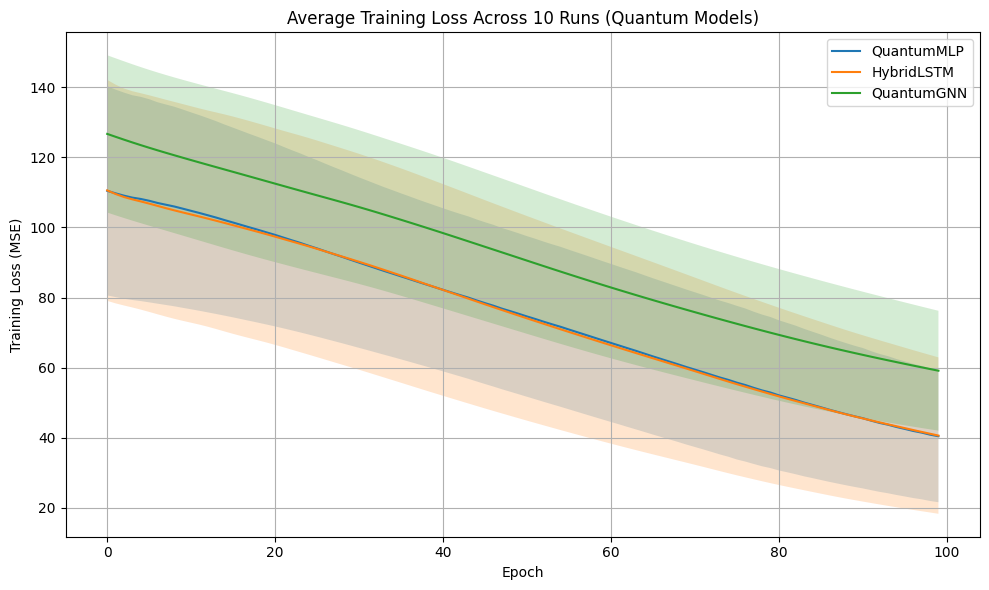

In [9]:
plt.figure(figsize=(10, 6))
for name, runs_losses in all_losses.items():
    losses_matrix = np.array([np.array(l) for l in runs_losses])
    mean_loss = losses_matrix.mean(axis=0)
    std_loss = losses_matrix.std(axis=0)
    epochs = np.arange(len(mean_loss))
    plt.plot(epochs, mean_loss, label=name)
    plt.fill_between(epochs, mean_loss - std_loss, mean_loss + std_loss, alpha=0.2)

plt.xlabel("Epoch")
plt.ylabel("Training Loss (MSE)")
plt.title("Average Training Loss Across 10 Runs (Quantum Models)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_qaoa_dataset_2.png", dpi=300)
plt.show()

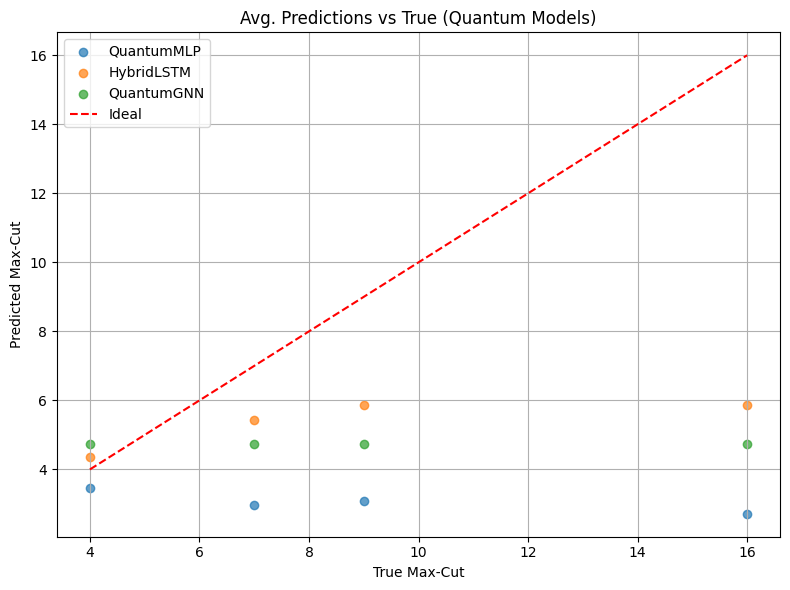

In [10]:
plt.figure(figsize=(8, 6))
true_vals = np.array(all_trues)

for name, runs_preds in all_preds.items():
    preds_matrix = np.array(runs_preds)
    mean_preds = preds_matrix.mean(axis=0)
    plt.scatter(true_vals, mean_preds, label=name, alpha=0.7)

lims = [min(true_vals.min(), mean_preds.min()), max(true_vals.max(), mean_preds.max())]
plt.plot(lims, lims, 'r--', label="Ideal")
plt.xlabel("True Max-Cut")
plt.ylabel("Predicted Max-Cut")
plt.title("Avg. Predictions vs True (Quantum Models)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("avg_pred_vs_true_qaoa_dataset_2.png", dpi=300)
plt.show()

In [11]:
results_lines = []
results_lines.append("--- Aggregated Test Evaluation over All Runs (Quantum Models) ---\n")

true_vals = np.array(all_trues)

for name, runs_preds in all_preds.items():
    preds_matrix = np.array(runs_preds)
    mean_preds = preds_matrix.mean(axis=0)
    std_preds = preds_matrix.std(axis=0)
    mse = mean_squared_error(true_vals, mean_preds)
    mae = mean_absolute_error(true_vals, mean_preds)
    approx_ratios = mean_preds / np.maximum(true_vals, 1e-6)
    mean_ratio = approx_ratios.mean()
    std_ratio = approx_ratios.std()
    results_lines.append(f"{name} Results:")
    results_lines.append(f"  MSE:            {mse:.4f}")
    results_lines.append(f"  MAE:            {mae:.4f}")
    results_lines.append(f"  Approx. Ratio:  {mean_ratio:.4f} ± {std_ratio:.4f}\n")

output_path = "results_qaoa_dataset_2.txt"
with open(output_path, "w") as f:
    f.write("\n".join(results_lines))

print(f"\n✅ Quantum results saved to {output_path}")


✅ Quantum results saved to results_qaoa_dataset_2.txt


## Random graphs only

In [12]:
def generate_dual_formulation_dataset(n_samples=300, n_min=4, n_max=16, test_ratio=0.2):
    data_vec, data_pyg = [], []

    for _ in range(n_samples):
        n = np.random.randint(n_min, n_max + 1)
        q = np.random.randn(n, n)
    
        q_sym = 0.5 * (q + q.T)
        sigma = np.random.choice([-1, 1], size=n)
        abs_q = np.abs(q_sym)
        lambda_vec = abs_q.sum(axis=1)
        lambda_diag = np.diag(lambda_vec)
        b = (q_sym + lambda_diag) @ sigma
        A = (q_sym / 4).copy()
        np.fill_diagonal(A, 0) 
        A[np.abs(A) < 1e-2] = 0
        G = nx.from_numpy_array(A)
        if len(G.edges) == 0:
            continue 
        for u, v in G.edges():
            G[u][v]['weight'] = A[u, v]
        cut = exact_maxcut(A)
        data_vec.append(graph_to_vector(A, cut))
        data_pyg.append(graph_to_pyg(A, cut, max_nodes=n_max))

    return train_test_split(data_pyg, test_size=test_ratio), train_test_split(data_vec, test_size=test_ratio)


In [13]:
runs = 10
model_names = ["QuantumMLP", "HybridLSTM", "QuantumGNN"]

all_losses = {name: [] for name in model_names}
all_preds = {name: [] for name in model_names}
all_trues = []

for run in range(runs):
    print(f"\n=== Seeded Run {run+1} ===")
    set_seed(run)
    (pyg_train, pyg_test), (vec_train, vec_test) = generate_dual_formulation_dataset()
    X_train, y_train, max_len = pad_vectors(vec_train)
    X_test, y_test, _ = pad_vectors(vec_test, max_len=max_len)
    qmlp = QuantumMLP(input_dim=X_train.shape[1])
    preds, true, losses = train(qmlp, X_train, y_train, X_test, y_test, name="QuantumMLP")
    all_losses["QuantumMLP"].append(losses)
    all_preds["QuantumMLP"].append(preds)
    if run == 0:
        all_trues = true
    qlstm = HybridLSTM(input_dim=X_train.shape[1])
    X_train_seq = X_train.unsqueeze(1)
    X_test_seq = X_test.unsqueeze(1)
    preds, _, losses = train(qlstm, X_train_seq, y_train, X_test_seq, y_test, name="HybridLSTM")
    all_losses["HybridLSTM"].append(losses)
    all_preds["HybridLSTM"].append(preds)
    qgnn = QuantumGNN(input_dim=pyg_train[0].x.shape[1])
    preds, _, losses = train_gnn(qgnn, pyg_train, pyg_test, name="QuantumGNN")
    all_losses["QuantumGNN"].append(losses)
    all_preds["QuantumGNN"].append(preds)


=== Seeded Run 1 ===
[QuantumMLP] Epoch 1: Loss = 41.7232
[QuantumMLP] Epoch 2: Loss = 41.2741
[QuantumMLP] Epoch 3: Loss = 40.7971
[QuantumMLP] Epoch 4: Loss = 40.3029
[QuantumMLP] Epoch 5: Loss = 39.8009
[QuantumMLP] Epoch 6: Loss = 39.2978
[QuantumMLP] Epoch 7: Loss = 38.7966
[QuantumMLP] Epoch 8: Loss = 38.2975
[QuantumMLP] Epoch 9: Loss = 37.8012
[QuantumMLP] Epoch 10: Loss = 37.3085
[QuantumMLP] Epoch 11: Loss = 36.8207
[QuantumMLP] Epoch 12: Loss = 36.3379
[QuantumMLP] Epoch 13: Loss = 35.8598
[QuantumMLP] Epoch 14: Loss = 35.3855
[QuantumMLP] Epoch 15: Loss = 34.9136
[QuantumMLP] Epoch 16: Loss = 34.4429
[QuantumMLP] Epoch 17: Loss = 33.9725
[QuantumMLP] Epoch 18: Loss = 33.5014
[QuantumMLP] Epoch 19: Loss = 33.0286
[QuantumMLP] Epoch 20: Loss = 32.5535
[QuantumMLP] Epoch 21: Loss = 32.0756
[QuantumMLP] Epoch 22: Loss = 31.5947
[QuantumMLP] Epoch 23: Loss = 31.1112
[QuantumMLP] Epoch 24: Loss = 30.6258
[QuantumMLP] Epoch 25: Loss = 30.1397
[QuantumMLP] Epoch 26: Loss = 29.6540

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[QuantumGNN] Epoch 1: Loss = 34.3021
[QuantumGNN] Epoch 2: Loss = 30.0812
[QuantumGNN] Epoch 3: Loss = 24.0380
[QuantumGNN] Epoch 4: Loss = 17.7605
[QuantumGNN] Epoch 5: Loss = 13.3241
[QuantumGNN] Epoch 6: Loss = 11.6774
[QuantumGNN] Epoch 7: Loss = 10.8675
[QuantumGNN] Epoch 8: Loss = 10.0552
[QuantumGNN] Epoch 9: Loss = 9.2927
[QuantumGNN] Epoch 10: Loss = 8.5325
[QuantumGNN] Epoch 11: Loss = 7.9072
[QuantumGNN] Epoch 12: Loss = 7.2868
[QuantumGNN] Epoch 13: Loss = 6.7161
[QuantumGNN] Epoch 14: Loss = 6.2492
[QuantumGNN] Epoch 15: Loss = 5.7926
[QuantumGNN] Epoch 16: Loss = 5.3981
[QuantumGNN] Epoch 17: Loss = 5.0386
[QuantumGNN] Epoch 18: Loss = 4.7070
[QuantumGNN] Epoch 19: Loss = 4.4068
[QuantumGNN] Epoch 20: Loss = 4.1490
[QuantumGNN] Epoch 21: Loss = 3.8935
[QuantumGNN] Epoch 22: Loss = 3.6947
[QuantumGNN] Epoch 23: Loss = 3.4762
[QuantumGNN] Epoch 24: Loss = 3.2976
[QuantumGNN] Epoch 25: Loss = 3.1336
[QuantumGNN] Epoch 26: Loss = 2.9761
[QuantumGNN] Epoch 27: Loss = 2.8296
[Q

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[QuantumGNN] Epoch 1: Loss = 30.3146
[QuantumGNN] Epoch 2: Loss = 26.4151
[QuantumGNN] Epoch 3: Loss = 22.9260
[QuantumGNN] Epoch 4: Loss = 19.3932
[QuantumGNN] Epoch 5: Loss = 16.2458
[QuantumGNN] Epoch 6: Loss = 13.9544
[QuantumGNN] Epoch 7: Loss = 12.5872
[QuantumGNN] Epoch 8: Loss = 11.5917
[QuantumGNN] Epoch 9: Loss = 10.5512
[QuantumGNN] Epoch 10: Loss = 8.9604
[QuantumGNN] Epoch 11: Loss = 7.1046
[QuantumGNN] Epoch 12: Loss = 5.4983
[QuantumGNN] Epoch 13: Loss = 4.2985
[QuantumGNN] Epoch 14: Loss = 3.7038
[QuantumGNN] Epoch 15: Loss = 3.3394
[QuantumGNN] Epoch 16: Loss = 3.0747
[QuantumGNN] Epoch 17: Loss = 2.8406
[QuantumGNN] Epoch 18: Loss = 2.6371
[QuantumGNN] Epoch 19: Loss = 2.4519
[QuantumGNN] Epoch 20: Loss = 2.3018
[QuantumGNN] Epoch 21: Loss = 2.1817
[QuantumGNN] Epoch 22: Loss = 2.0691
[QuantumGNN] Epoch 23: Loss = 1.9574
[QuantumGNN] Epoch 24: Loss = 1.8616
[QuantumGNN] Epoch 25: Loss = 1.7860
[QuantumGNN] Epoch 26: Loss = 1.7047
[QuantumGNN] Epoch 27: Loss = 1.6510
[

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[QuantumGNN] Epoch 1: Loss = 33.1185
[QuantumGNN] Epoch 2: Loss = 28.7555
[QuantumGNN] Epoch 3: Loss = 24.9406
[QuantumGNN] Epoch 4: Loss = 20.9860
[QuantumGNN] Epoch 5: Loss = 17.2503
[QuantumGNN] Epoch 6: Loss = 14.7692
[QuantumGNN] Epoch 7: Loss = 12.9294
[QuantumGNN] Epoch 8: Loss = 11.9558
[QuantumGNN] Epoch 9: Loss = 11.3131
[QuantumGNN] Epoch 10: Loss = 10.8337
[QuantumGNN] Epoch 11: Loss = 10.2592
[QuantumGNN] Epoch 12: Loss = 9.4956
[QuantumGNN] Epoch 13: Loss = 8.8701
[QuantumGNN] Epoch 14: Loss = 8.3131
[QuantumGNN] Epoch 15: Loss = 7.7596
[QuantumGNN] Epoch 16: Loss = 7.2836
[QuantumGNN] Epoch 17: Loss = 6.7574
[QuantumGNN] Epoch 18: Loss = 6.3056
[QuantumGNN] Epoch 19: Loss = 5.8990
[QuantumGNN] Epoch 20: Loss = 5.4769
[QuantumGNN] Epoch 21: Loss = 5.1413
[QuantumGNN] Epoch 22: Loss = 4.8337
[QuantumGNN] Epoch 23: Loss = 4.5784
[QuantumGNN] Epoch 24: Loss = 4.3503
[QuantumGNN] Epoch 25: Loss = 4.1314
[QuantumGNN] Epoch 26: Loss = 3.9603
[QuantumGNN] Epoch 27: Loss = 3.7584

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[QuantumGNN] Epoch 1: Loss = 32.0214
[QuantumGNN] Epoch 2: Loss = 27.4496
[QuantumGNN] Epoch 3: Loss = 23.0810
[QuantumGNN] Epoch 4: Loss = 18.9646
[QuantumGNN] Epoch 5: Loss = 14.9371
[QuantumGNN] Epoch 6: Loss = 12.1035
[QuantumGNN] Epoch 7: Loss = 10.5386
[QuantumGNN] Epoch 8: Loss = 8.6790
[QuantumGNN] Epoch 9: Loss = 7.3082
[QuantumGNN] Epoch 10: Loss = 6.2915
[QuantumGNN] Epoch 11: Loss = 5.5471
[QuantumGNN] Epoch 12: Loss = 4.9922
[QuantumGNN] Epoch 13: Loss = 4.5352
[QuantumGNN] Epoch 14: Loss = 4.1478
[QuantumGNN] Epoch 15: Loss = 3.8290
[QuantumGNN] Epoch 16: Loss = 3.5590
[QuantumGNN] Epoch 17: Loss = 3.3216
[QuantumGNN] Epoch 18: Loss = 3.0996
[QuantumGNN] Epoch 19: Loss = 2.9663
[QuantumGNN] Epoch 20: Loss = 2.7325
[QuantumGNN] Epoch 21: Loss = 2.5586
[QuantumGNN] Epoch 22: Loss = 2.4100
[QuantumGNN] Epoch 23: Loss = 2.2846
[QuantumGNN] Epoch 24: Loss = 2.1664
[QuantumGNN] Epoch 25: Loss = 2.0390
[QuantumGNN] Epoch 26: Loss = 1.9523
[QuantumGNN] Epoch 27: Loss = 1.8739
[Qu

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[QuantumGNN] Epoch 1: Loss = 31.0317
[QuantumGNN] Epoch 2: Loss = 23.3432
[QuantumGNN] Epoch 3: Loss = 18.0336
[QuantumGNN] Epoch 4: Loss = 14.7580
[QuantumGNN] Epoch 5: Loss = 13.1092
[QuantumGNN] Epoch 6: Loss = 12.2649
[QuantumGNN] Epoch 7: Loss = 11.4925
[QuantumGNN] Epoch 8: Loss = 10.4836
[QuantumGNN] Epoch 9: Loss = 9.6004
[QuantumGNN] Epoch 10: Loss = 8.8319
[QuantumGNN] Epoch 11: Loss = 8.0195
[QuantumGNN] Epoch 12: Loss = 7.2859
[QuantumGNN] Epoch 13: Loss = 6.6544
[QuantumGNN] Epoch 14: Loss = 6.1087
[QuantumGNN] Epoch 15: Loss = 5.6076
[QuantumGNN] Epoch 16: Loss = 5.1949
[QuantumGNN] Epoch 17: Loss = 4.8115
[QuantumGNN] Epoch 18: Loss = 4.4909
[QuantumGNN] Epoch 19: Loss = 4.2206
[QuantumGNN] Epoch 20: Loss = 4.0063
[QuantumGNN] Epoch 21: Loss = 3.7234
[QuantumGNN] Epoch 22: Loss = 3.4614
[QuantumGNN] Epoch 23: Loss = 3.2480
[QuantumGNN] Epoch 24: Loss = 3.0586
[QuantumGNN] Epoch 25: Loss = 2.8996
[QuantumGNN] Epoch 26: Loss = 2.7549
[QuantumGNN] Epoch 27: Loss = 2.6003
[Q

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[QuantumGNN] Epoch 1: Loss = 39.2684
[QuantumGNN] Epoch 2: Loss = 32.1141
[QuantumGNN] Epoch 3: Loss = 25.9042
[QuantumGNN] Epoch 4: Loss = 20.8403
[QuantumGNN] Epoch 5: Loss = 15.9781
[QuantumGNN] Epoch 6: Loss = 12.7270
[QuantumGNN] Epoch 7: Loss = 11.1204
[QuantumGNN] Epoch 8: Loss = 10.0643
[QuantumGNN] Epoch 9: Loss = 8.6724
[QuantumGNN] Epoch 10: Loss = 7.5575
[QuantumGNN] Epoch 11: Loss = 6.7772
[QuantumGNN] Epoch 12: Loss = 6.1054
[QuantumGNN] Epoch 13: Loss = 5.5496
[QuantumGNN] Epoch 14: Loss = 5.0657
[QuantumGNN] Epoch 15: Loss = 4.6410
[QuantumGNN] Epoch 16: Loss = 4.2894
[QuantumGNN] Epoch 17: Loss = 3.9965
[QuantumGNN] Epoch 18: Loss = 3.7450
[QuantumGNN] Epoch 19: Loss = 3.5023
[QuantumGNN] Epoch 20: Loss = 3.3006
[QuantumGNN] Epoch 21: Loss = 3.1333
[QuantumGNN] Epoch 22: Loss = 2.9536
[QuantumGNN] Epoch 23: Loss = 2.7731
[QuantumGNN] Epoch 24: Loss = 2.6248
[QuantumGNN] Epoch 25: Loss = 2.4879
[QuantumGNN] Epoch 26: Loss = 2.3305
[QuantumGNN] Epoch 27: Loss = 2.2182
[Q

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[QuantumGNN] Epoch 1: Loss = 30.2843
[QuantumGNN] Epoch 2: Loss = 27.6137
[QuantumGNN] Epoch 3: Loss = 24.7148
[QuantumGNN] Epoch 4: Loss = 21.4537
[QuantumGNN] Epoch 5: Loss = 17.8485
[QuantumGNN] Epoch 6: Loss = 14.8127
[QuantumGNN] Epoch 7: Loss = 12.0001
[QuantumGNN] Epoch 8: Loss = 10.3183
[QuantumGNN] Epoch 9: Loss = 8.6651
[QuantumGNN] Epoch 10: Loss = 7.3860
[QuantumGNN] Epoch 11: Loss = 6.4075
[QuantumGNN] Epoch 12: Loss = 5.6738
[QuantumGNN] Epoch 13: Loss = 5.0802
[QuantumGNN] Epoch 14: Loss = 4.5499
[QuantumGNN] Epoch 15: Loss = 4.1003
[QuantumGNN] Epoch 16: Loss = 3.7808
[QuantumGNN] Epoch 17: Loss = 3.4842
[QuantumGNN] Epoch 18: Loss = 3.2085
[QuantumGNN] Epoch 19: Loss = 3.0004
[QuantumGNN] Epoch 20: Loss = 2.7740
[QuantumGNN] Epoch 21: Loss = 2.5531
[QuantumGNN] Epoch 22: Loss = 2.4168
[QuantumGNN] Epoch 23: Loss = 2.2743
[QuantumGNN] Epoch 24: Loss = 2.1118
[QuantumGNN] Epoch 25: Loss = 1.9840
[QuantumGNN] Epoch 26: Loss = 1.8794
[QuantumGNN] Epoch 27: Loss = 1.8036
[Q

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[QuantumGNN] Epoch 1: Loss = 36.2089
[QuantumGNN] Epoch 2: Loss = 30.2297
[QuantumGNN] Epoch 3: Loss = 24.2025
[QuantumGNN] Epoch 4: Loss = 19.0753
[QuantumGNN] Epoch 5: Loss = 14.7171
[QuantumGNN] Epoch 6: Loss = 12.0670
[QuantumGNN] Epoch 7: Loss = 11.1013
[QuantumGNN] Epoch 8: Loss = 9.6145
[QuantumGNN] Epoch 9: Loss = 8.4880
[QuantumGNN] Epoch 10: Loss = 7.5732
[QuantumGNN] Epoch 11: Loss = 6.8002
[QuantumGNN] Epoch 12: Loss = 6.1529
[QuantumGNN] Epoch 13: Loss = 5.6297
[QuantumGNN] Epoch 14: Loss = 5.1567
[QuantumGNN] Epoch 15: Loss = 4.7667
[QuantumGNN] Epoch 16: Loss = 4.4468
[QuantumGNN] Epoch 17: Loss = 4.1472
[QuantumGNN] Epoch 18: Loss = 3.8851
[QuantumGNN] Epoch 19: Loss = 3.6288
[QuantumGNN] Epoch 20: Loss = 3.3955
[QuantumGNN] Epoch 21: Loss = 3.2019
[QuantumGNN] Epoch 22: Loss = 3.0190
[QuantumGNN] Epoch 23: Loss = 2.8510
[QuantumGNN] Epoch 24: Loss = 2.7036
[QuantumGNN] Epoch 25: Loss = 2.5568
[QuantumGNN] Epoch 26: Loss = 2.4308
[QuantumGNN] Epoch 27: Loss = 2.3271
[Qu

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[QuantumGNN] Epoch 1: Loss = 31.7374
[QuantumGNN] Epoch 2: Loss = 27.4046
[QuantumGNN] Epoch 3: Loss = 21.2244
[QuantumGNN] Epoch 4: Loss = 16.1848
[QuantumGNN] Epoch 5: Loss = 13.2032
[QuantumGNN] Epoch 6: Loss = 11.7486
[QuantumGNN] Epoch 7: Loss = 10.9207
[QuantumGNN] Epoch 8: Loss = 9.7988
[QuantumGNN] Epoch 9: Loss = 8.9523
[QuantumGNN] Epoch 10: Loss = 8.1224
[QuantumGNN] Epoch 11: Loss = 7.4429
[QuantumGNN] Epoch 12: Loss = 6.7317
[QuantumGNN] Epoch 13: Loss = 6.1691
[QuantumGNN] Epoch 14: Loss = 5.6210
[QuantumGNN] Epoch 15: Loss = 5.1358
[QuantumGNN] Epoch 16: Loss = 4.5686
[QuantumGNN] Epoch 17: Loss = 3.9361
[QuantumGNN] Epoch 18: Loss = 3.2646
[QuantumGNN] Epoch 19: Loss = 2.8354
[QuantumGNN] Epoch 20: Loss = 2.4704
[QuantumGNN] Epoch 21: Loss = 2.2411
[QuantumGNN] Epoch 22: Loss = 2.0685
[QuantumGNN] Epoch 23: Loss = 1.9798
[QuantumGNN] Epoch 24: Loss = 1.8694
[QuantumGNN] Epoch 25: Loss = 1.7739
[QuantumGNN] Epoch 26: Loss = 1.7214
[QuantumGNN] Epoch 27: Loss = 1.6413
[Qu

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[QuantumGNN] Epoch 1: Loss = 32.9342
[QuantumGNN] Epoch 2: Loss = 28.2935
[QuantumGNN] Epoch 3: Loss = 23.6330
[QuantumGNN] Epoch 4: Loss = 18.8195
[QuantumGNN] Epoch 5: Loss = 13.8194
[QuantumGNN] Epoch 6: Loss = 11.0035
[QuantumGNN] Epoch 7: Loss = 9.7442
[QuantumGNN] Epoch 8: Loss = 8.8005
[QuantumGNN] Epoch 9: Loss = 8.0603
[QuantumGNN] Epoch 10: Loss = 7.1030
[QuantumGNN] Epoch 11: Loss = 6.4130
[QuantumGNN] Epoch 12: Loss = 5.7652
[QuantumGNN] Epoch 13: Loss = 5.1872
[QuantumGNN] Epoch 14: Loss = 4.7350
[QuantumGNN] Epoch 15: Loss = 4.3501
[QuantumGNN] Epoch 16: Loss = 4.0340
[QuantumGNN] Epoch 17: Loss = 3.7384
[QuantumGNN] Epoch 18: Loss = 3.4979
[QuantumGNN] Epoch 19: Loss = 3.2818
[QuantumGNN] Epoch 20: Loss = 3.1187
[QuantumGNN] Epoch 21: Loss = 2.9055
[QuantumGNN] Epoch 22: Loss = 2.7186
[QuantumGNN] Epoch 23: Loss = 2.5950
[QuantumGNN] Epoch 24: Loss = 2.4524
[QuantumGNN] Epoch 25: Loss = 2.3318
[QuantumGNN] Epoch 26: Loss = 2.2048
[QuantumGNN] Epoch 27: Loss = 2.1117
[Qua

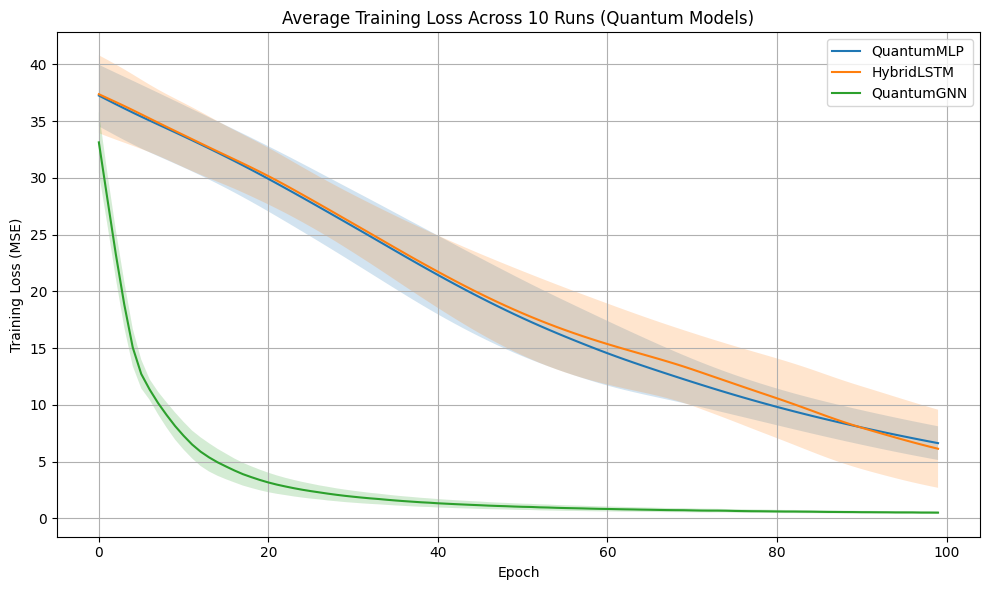

In [14]:
plt.figure(figsize=(10, 6))
for name, runs_losses in all_losses.items():
    losses_matrix = np.array([np.array(l) for l in runs_losses])
    mean_loss = losses_matrix.mean(axis=0)
    std_loss = losses_matrix.std(axis=0)
    epochs = np.arange(len(mean_loss))

    plt.plot(epochs, mean_loss, label=name)
    plt.fill_between(epochs, mean_loss - std_loss, mean_loss + std_loss, alpha=0.2)

plt.xlabel("Epoch")
plt.ylabel("Training Loss (MSE)")
plt.title("Average Training Loss Across 10 Runs (Quantum Models)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_er_dataset_2.png", dpi=300)
plt.show()

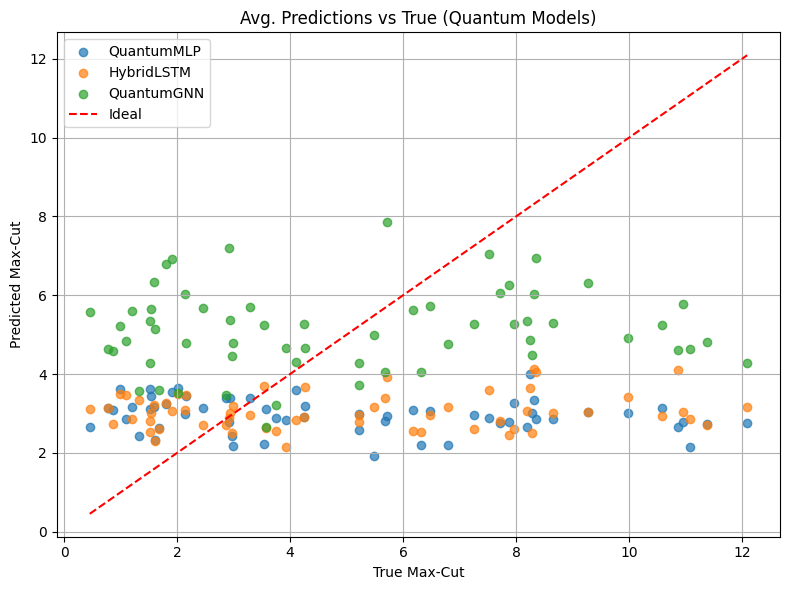

In [15]:
plt.figure(figsize=(8, 6))
true_vals = np.array(all_trues)

for name, runs_preds in all_preds.items():
    preds_matrix = np.array(runs_preds)
    mean_preds = preds_matrix.mean(axis=0)
    plt.scatter(true_vals, mean_preds, label=name, alpha=0.7)

lims = [min(true_vals.min(), mean_preds.min()), max(true_vals.max(), mean_preds.max())]
plt.plot(lims, lims, 'r--', label="Ideal")
plt.xlabel("True Max-Cut")
plt.ylabel("Predicted Max-Cut")
plt.title("Avg. Predictions vs True (Quantum Models)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("avg_pred_vs_true_er_dataset_2.png", dpi=300)
plt.show()

In [16]:
results_lines = []
results_lines.append("--- Aggregated Test Evaluation over All Runs (Quantum Models) ---\n")

true_vals = np.array(all_trues)

for name, runs_preds in all_preds.items():
    preds_matrix = np.array(runs_preds)
    mean_preds = preds_matrix.mean(axis=0)
    std_preds = preds_matrix.std(axis=0)
    mse = mean_squared_error(true_vals, mean_preds)
    mae = mean_absolute_error(true_vals, mean_preds)
    approx_ratios = mean_preds / np.maximum(true_vals, 1e-6)
    mean_ratio = approx_ratios.mean()
    std_ratio = approx_ratios.std()
    results_lines.append(f"{name} Results:")
    results_lines.append(f"  MSE:            {mse:.4f}")
    results_lines.append(f"  MAE:            {mae:.4f}")
    results_lines.append(f"  Approx. Ratio:  {mean_ratio:.4f} ± {std_ratio:.4f}\n")

output_path = "results_er_dataset_2.txt"
with open(output_path, "w") as f:
    f.write("\n".join(results_lines))

print(f"\n✅ Quantum results saved to {output_path}")


✅ Quantum results saved to results_er_dataset_2.txt
